In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\Fig2"


In [3]:
path_figure

'C:\\Users\\coren\\Documents\\PhD\\paper\\PandC\\Fig2'

In [4]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [5]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume_smooth', window=10)


Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.5
dry_wet_ratio_spore = 0.3
density_spore = 1e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio

baseline = final_data[final_data['time_since_begin_h'] == 0]

baseline_volume = baseline.groupby('unique_id')['spore_volume'].first()
final_data['adjusted_spore_volume'] = final_data.groupby('unique_id')['spore_volume'].transform(lambda x: x - baseline_volume[x.name])

final_data['tot_volume'] = final_data['adjusted_spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['adjusted_spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore

#IMPORTANT MAKE A CHOICE WHETHER OR NOT TO INCLUDE SPORES
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']
# final_data['totC_tot'] = final_data['totC_hypha']


final_data = final_data.reset_index(drop=True)
final_data_select = final_data.loc[final_data['time_since_begin_h_shifted']<=150]

max_c_rate_time = final_data_select.loc[final_data_select.groupby('unique_id')['C_rate'].idxmax(), ['unique_id', 'time_since_begin_h_shifted']]

# Step 2: Merge this information back to the original DataFrame
final_data = final_data.merge(max_c_rate_time, on='unique_id', suffixes=('', '_max_c_rate'))

In [6]:
import numpy as np
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
density*dry_wet_ratio*carbon_ratio*np.pi*3**2

4.241150082346221e-06

<AxesSubplot: xlabel='time_since_begin_h_shifted', ylabel='hull_speed'>

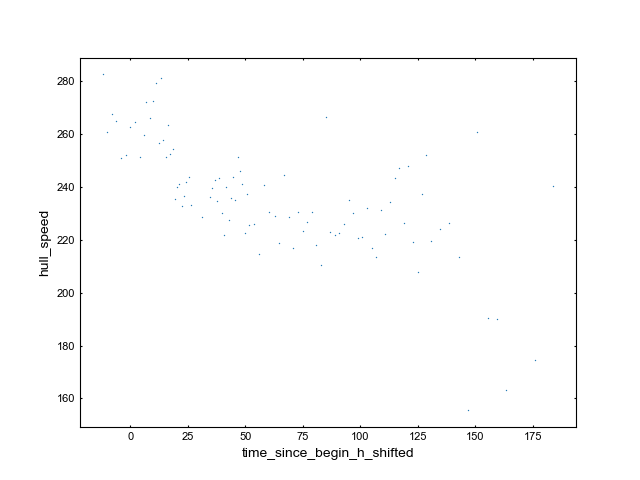

In [7]:
select = final_data[final_data['unique_id'] == 84_20220621]
select = select[select['time_since_begin_h_shifted'] <= 200]

fig,ax = plt.subplots()
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='hull_speed', ax=ax, lw=1)
# ax.vlines(select['time_since_begin_h_shifted_max_c_rate'].iloc[0],0,1e6,color= "red")

In [8]:
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'totC_tot',f'derivative_C', window=5)

calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instant_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_BV', window=5)
final_data['instant_BV_dens'] = final_data['derivative_BV']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_length_study',f'derivative_L', window=5)
final_data['instant_L_dens'] = final_data['derivative_L']/final_data['derivative_area']
final_data['instant_C_dens'] = final_data['derivative_C']/final_data['derivative_area']

final_data['instant_radius'] = final_data['instant_BV_dens']/final_data['instant_SA_dens']*2
final_data['strain'] = final_data['strain'].replace("A5V","A5")


In [9]:
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")
df['fungus'] = df['fungus'].replace("A5V","A5")

df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}

n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
strain_to_color = {"C2": (0.17058823529411765, 0.4946558433997788, 0.9667184042691874),
 "A5": (0.16666666666666663, 0.8660254037844386, 0.8660254037844387),
 "Agg": (0.503921568627451, 0.9999810273487268, 0.7049255469061472),
 "Clarum": (0.8333333333333333, 0.8660254037844387, 0.5000000000000001),
 "C3": (1.0, 0.4946558433997788, 0.2558427775944356)}

df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)


In [10]:
select[select['strain']!="A5V "]['strain'].unique()

array(['A5'], dtype=object)

2024-04-02 22:07:55,930-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


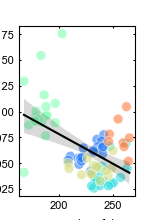

In [16]:
plt.style.use('presentation.mplstyle')

bin_size = 30
cm = 1/2.54  # centimeters in inches
select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.025]
select= select[select['real_root']=="Carrot Toby"]
select= select[select['fungalC']=="100P/100N/100C"]
select= select[select['strain']!="A5V "]

# select= select[select['strain']=="C2"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
# select = select[select['time_hour_binned'] <= 50]
# select = select[select['time_hour_binned'] >= 0]

summary = select.groupby(["strain", 'time_hour_binned']).agg({
    'hull_speed': 'median',
    'instant_SA_dens': 'median',
    'radius': 'median',
    'instant_BV_dens': 'count',
    'instant_L_dens': 'median',
    'instant_C_dens': 'median',
    
}).rename(columns={'instant_BV_dens': 'count'})
summary = summary[summary['count']>7]
summary = summary.reset_index()
fig,ax = plt.subplots(figsize = (3.8*cm,5.6*cm))

sns.scatterplot(summary, x='hull_speed', y='instant_C_dens',hue="strain",s=50,palette=strain_to_color,alpha = 0.6)
sns.regplot(data=summary, x='hull_speed', y='instant_C_dens',scatter = False,color = "black")
summary = select.groupby("strain")[['hull_speed','hull_speed_binned','instant_SA_dens','radius','instant_BV_dens','instant_L_dens','instant_C_dens']].median()
# sns.scatterplot(summary, x='hull_speed', y='instant_C_dens',hue="strain",s=200,palette=strain_to_color)
ax.legend('')
summary['size_point'] = 20
summary['fungus'] = summary.index
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel('$d_{Carbon}$ ($\mu g/mm^2$)')
plt.legend().remove()
# plt.tight_layout()

plt.savefig(os.path.join(path_figure,'Figure2A.pdf'), transparent=True, bbox_inches='tight')


In [12]:
summary = select.groupby(["strain", 'time_hour_binned']).agg({
    'hull_speed': 'median',
    'instant_SA_dens': 'median',
    'radius': 'median',
    'instant_BV_dens': 'count',
    'instant_L_dens': 'median',
    'instant_C_dens': 'median',
    
}).rename(columns={'instant_BV_dens': 'count'})
summary = summary[summary['count']>7]
summary

hull_speed  instant_SA_dens    radius  count  \
strain time_hour_binned                                                 
A5     -30               234.657491     27013.542449  2.167435      9   
       -20               232.294729     15034.920794  2.147137     11   
       -10               241.266815     15691.049012  2.294707     20   
        0                262.994865     19261.292216  2.272681     33   
        10               256.882451     15270.482370  2.221096     38   
...                             ...              ...       ...    ...   
Clarum  60               248.520743     18720.849159  2.077696     14   
        70               243.483729     18980.321851  2.063873     20   
        80               226.119706     19850.593537  2.058350     19   
        90               249.859334     21406.775516  2.038468     18   
        100              234.515519     19052.025800  2.026076     15   

                         instant_L_dens  instant_C_dens  
strain time_hour_binned                                  
A5     -30                  1007.304243        0.004617  
       -20                   841.617419        0.002588  
       -10                   774.773176        0.003249  
        0                    965.518149        0.004527  
        10                   882.064258        0.003611  
...                                 ...             ...  
Clarum  60                  1119.434217        0.004480  
        70                  1186.175253        0.004243  
        80                  1105.256239        0.005475  
        90                  1388.789974        0.006201  
        100                 1167.950330        0.004662  

[76 rows x 6 columns]

In [13]:
select = final_data[final_data['real_root']=="Carrot Toby"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
select = select[select['C_rate'] >= 0]
max_c_rate_time = select.loc[select.groupby('unique_id')['time_since_begin_h_shifted'].idxmax(), ['folder','unique_id','time_since_begin_h']]
max_c_rate_time.to_csv('list_last_folder.csv')

2024-04-02 22:10:45,390-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


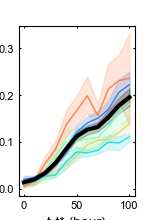

In [18]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_data is your DataFrame and it contains a 'unique_id' column
# Group by 'time_hour_binned' and filter out groups with less than 3 unique IDs
tmax = 150
select = final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['fungalC']=="100P/100N/100C"]

select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
select = select[select['time_hour_binned'] <= 50]
select = select[select['C_rate'] >= 0]
select= select[select['strain']!="A5V "]

select = select.copy()
select['time_reshift'] = select['time_hour_binned']+50



grouped = select.groupby('time_hour_binned')
filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 7)

# Now, use this filtered data for your plots
fig,ax = plt.subplots(figsize = (3.8*cm,5.6*cm))
sns.lineplot(data=filtered_groups, x='time_reshift', y='C_rate', hue='strain', ax=ax, palette=strain_to_color, lw=1)

# Mean line plot
sns.lineplot(data=filtered_groups, x='time_reshift', y='C_rate', ax=ax, color='black', estimator='mean', lw=3, ls="-")

ax.set_xlabel('t-t* (hour)')
ax.set_ylabel('$\Phi_C$ ($\mu g/h$)')
# ax.set_ylim(0)
plt.legend().remove()
# plt.tight_layout()
# Save the figure
plt.savefig(os.path.join(path_figure, 'Figure2B.pdf'), transparent=True, bbox_inches='tight')
